In [ ]:
print(__doc__)
import matplotlib.pyplot as plt
import numpy as np
import fitbit
import gather_keys_oauth2 as Oauth2
import pandas as pd 
import datetime
import os
from scipy import stats

CLIENT_ID = '239Z9F'
CLIENT_SECRET = 'fcd469fed13e810f60d314919d9cc944'

In [ ]:
server = Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET)
server.browser_authorize()
ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token'])
auth2_client = fitbit.Fitbit(CLIENT_ID, CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)

In [ ]:
# Pull down the sleep data for a specified date range. 
# Note that the FB API only allows up to 100 requests per hour!

start_time = pd.datetime(year = 2020, month = 8, day = 1)
end_time = pd.datetime(year = 2021, month = 5, day = 25)
all_dates = pd.date_range(start=start_time, end = end_time)

date = []
duration = []
start_time = []
total_sleep_mins = []
deep_mins = []
light_mins = []
wake_mins = []
rem_mins = []

for d in all_dates:
    
    d = d.date().strftime("%Y-%m-%d")
    day_data = auth2_client.sleep(date=d)

    if len(day_data['sleep']) == 0: 
        continue
    elif not 'stages' in day_data['summary']:
        continue

    date.append(day_data['sleep'][0]['dateOfSleep'])
    start_time.append(
        datetime.datetime.strptime(day_data['sleep'][0]['startTime'], '%Y-%m-%dT%H:%M:%S.%f').time())
    total_sleep_mins.append(day_data['sleep'][0]['minutesAsleep'])
    deep_mins.append(day_data['summary']['stages']['deep'])
    light_mins.append(day_data['summary']['stages']['light'])
    wake_mins.append(day_data['summary']['stages']['wake'])
    rem_mins.append(day_data['summary']['stages']['rem'])

sleep_data = pd.DataFrame(
    {
        'date': date, 
        'start_time': start_time,
        'total_sleep_mins': total_sleep_mins,
        'deep_mins': deep_mins,
        'light_mins': light_mins,
        'wake_mins': wake_mins,
        'rem_mins': rem_mins
    })


In [ ]:
sleep_data.to_csv('data/sleep.csv', index=False)

In [683]:
sleep_data = pd.read_csv('data/sleep.csv')

In [684]:
# I've been hand-recording some daily metrics, in particular my general mood and how well I felt I had slept
general_data_source = pd.read_csv('data/daylio_export_2021_05_23.csv')

def get_sleep_status(x):
    sleep_status = 'unknown'
    if "good sleep" in x:
        sleep_status = 'good'
    elif "medium sleep" in x:
        sleep_status = 'medium'
    elif "bad sleep" in x:
        sleep_status = 'bad'
    return sleep_status

general_data = pd.DataFrame(
    {
        'date': general_data_source.full_date,
        'sleep': general_data_source.activities.apply(lambda x: get_sleep_status(str(x))),
        'activities': general_data_source.activities,
        'mood': general_data_source.mood
    }
)


<AxesSubplot:ylabel='sleep'>

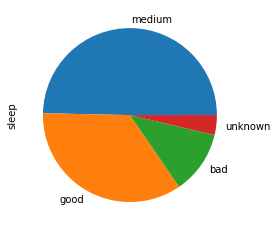

In [685]:
general_data['sleep'].value_counts().plot(kind='pie')

In [686]:
run_day_before = pd.DataFrame(
    {
        'run_day_before': general_data_source.activities.apply(lambda x: 'run' in str(x)),
        'date': general_data.date.apply(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d') + datetime.timedelta(days=1)).strftime('%Y-%m-%d') )
    })
general_data = general_data.merge(run_day_before, on='date')

In [687]:
sleep_data = sleep_data.merge(general_data, on='date')

In [688]:
sleep_mood_crosstab = pd.crosstab(sleep_data.sleep, sleep_data.mood)
sleep_mood_crosstab

mood,bad,good,meh,ok
sleep,,,,
bad,2,0,10,6
good,0,13,1,63
medium,2,1,6,80
unknown,0,0,0,2


In [689]:
def chi2_table(series1, series2, to_csv = False, csv_name = None, 
                prop= False):
    
    if type(series1) != list:
        crosstab = pd.crosstab(series1, series2)
        crosstab2 = pd.crosstab(series1, series2, margins= True)
        crosstab_proprow = round(crosstab2.div(crosstab2.iloc[:,-1], axis=0).mul(100, axis=0), 2)
        crosstab_propcol = round(crosstab2.div(crosstab2.iloc[-1,:], axis=1).mul(100, axis=1), 2)
        chi2, p, dof, expected = stats.chi2_contingency(crosstab)
        
        if prop == False:
            print("\n",
          f"Chi-Square test between " + series1.name + " and " + series2.name,
          "\n", "\n",
          crosstab2,
          "\n", "\n",
          f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
            
            if to_csv == True:
                if csv_name == None:
                    csv_name = f"{series2.name}.csv"
                                             
                file = open(csv_name, 'a')
                file.write(f"{crosstab2.columns.name}\n")
                file.close()
                crosstab2.to_csv(csv_name, header= True, mode= 'a')
                file = open(csv_name, 'a')
                file.write(f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
                file.write("\n")
                file.close()              
                
        if prop == 'Row':
            print("\n",
          f"Chi-Square test between " + series1.name + " and " + series2.name,
          "\n", "\n",
          crosstab_proprow,
          "\n", "\n",
          f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
            
            if to_csv == True:
                if csv_name == None:
                    csv_name = f"{series2.name}.csv"
                
                file = open(csv_name, 'a')
                file.write(f"{crosstab_proprow.columns.name}\n")
                file.close()
                crosstab_proprow.to_csv(csv_name, header= True, mode= 'a')
                file = open(csv_name, 'a')
                file.write(f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
                file.write("\n")
                file.close()

        if prop == 'Col':
            print("\n",
          f"Chi-Square test between " + series1.name + " and " + series2.name,
          "\n", "\n",
          crosstab_propcol,
          "\n", "\n",
          f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")

            if to_csv == True:
                if csv_name == None:
                    csv_name = f"{series2.name}.csv"
                    
                file = open(csv_name, 'a')
                file.write(f"{crosstab_propcol.columns.name}\n")
                file.close()
                crosstab_propcol.to_csv(csv_name, header= True, mode= 'a')
                file = open(csv_name, 'a')
                file.write(f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
                file.write("\n")
                file.close()

    elif type(series1) == list and type(series2) == list:
        for entry2 in series2:
            for entry1 in series1:
                crosstab = pd.crosstab(entry1, entry2)
                crosstab2 = pd.crosstab(entry1, entry2, margins= True)
                crosstab_proprow = round(crosstab2.div(crosstab2.iloc[:,-1], axis=0).mul(100, axis=0), 2)
                crosstab_propcol = round(crosstab2.div(crosstab2.iloc[-1,:], axis=1).mul(100, axis=1), 2)
                chi2, p, dof, expected = stats.chi2_contingency(crosstab)
                
                if prop == False:
            
                    print("\n",
          f"Chi-Square test between " + entry1.name + " and " + entry2.name,
          "\n", "\n",
          crosstab2,
          "\n", "\n",
          f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
            
                    if to_csv == True:
                        
                        file = open("%s.csv" %(entry2.name), 'a')
                        file.write(f"{crosstab2.columns.name}\n")
                        file.close()
                        crosstab2.to_csv("%s.csv" %(entry2.name), header= True, mode= 'a')
                        file = open("%s.csv" %(entry2.name), 'a')
                        file.write(f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
                        file.write("\n")
                        file.close()                        

                if prop == 'Row':
            
                    print("\n",
          f"Chi-Square test between " + entry1.name + " and " + entry2.name,
          "\n", "\n",
          crosstab_proprow,
          "\n", "\n",
          f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
            
                    if to_csv == True:
                        file = open("%s.csv" %(entry2.name), 'a')
                        file.write(f"{crosstab_proprow.columns.name}\n")
                        file.close()
                        crosstab_proprow.to_csv("%s.csv" %(entry2.name), header= True, mode= 'a')
                        file = open("%s.csv" %(entry2.name), 'a')
                        file.write(f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
                        file.write("\n")
                        file.close()
                    
                if prop == 'Col':
            
                    print("\n",
          f"Chi-Square test between " + entry1.name + " and " + entry2.name,
          "\n", "\n",
          crosstab_propcol,
          "\n", "\n",
          f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
            
                    if to_csv == True:
                        file = open("%s.csv" %(entry2.name), 'a')
                        file.write(f"{crosstab_propcol.columns.name}\n")
                        file.close()
                        crosstab_propcol.to_csv("%s.csv" %(entry2.name), header= True, mode= 'a')
                        file = open("%s.csv" %(entry2.name), 'a')
                        file.write(f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
                        file.write("\n")
                        file.close()


    elif type(series1) == list:
        for entry in series1:
            crosstab = pd.crosstab(entry, series2)
            crosstab2 = pd.crosstab(entry, series2, margins= True)
            crosstab_proprow = round(crosstab2.div(crosstab2.iloc[:,-1], axis=0).mul(100, axis=0), 2)
            crosstab_propcol = round(crosstab2.div(crosstab2.iloc[-1,:], axis=1).mul(100, axis=1), 2)
            chi2, p, dof, expected = stats.chi2_contingency(crosstab)
            
            if prop == False:
                print("\n",
          f"Chi-Square test between " + entry.name + " and " + series2.name,
          "\n", "\n",
          crosstab2,
          "\n", "\n",
          f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
            
                if to_csv == True:
                    file = open("%s.csv" %(series2.name), 'a')
                    file.write(f"{crosstab2.columns.name}\n")
                    file.close()
                    crosstab2.to_csv("%s.csv" %(series2.name), header= True, mode= 'a')
                    file = open("%s.csv" %(series2.name), 'a')
                    file.write(f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
                    file.write("\n")
                    file.close()

            if prop == 'Row':
                print("\n",
          f"Chi-Square test between " + entry.name + " and " + series2.name,
          "\n", "\n",
          crosstab_proprow,
          "\n", "\n",
          f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
            
                if to_csv == True:
                    file = open("%s.csv" %(series2.name), 'a')
                    file.write(f"{crosstab_proprow.columns.name}\n")
                    file.close()
                    crosstab_proprow.to_csv("%s.csv" %(series2.name), header= True, mode= 'a')
                    file = open("%s.csv" %(series2.name), 'a')
                    file.write(f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
                    file.write("\n")
                    file.close()

            if prop == 'Col':
                print("\n",
          f"Chi-Square test between " + entry.name + " and " + series2.name,
          "\n", "\n",
          crosstab_propcol,
          "\n", "\n",
          f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
            
                if to_csv == True:
                    file = open("%s.csv" %(series2.name), 'a')
                    file.write(f"{crosstab_propcol.columns.name}\n")
                    file.close()
                    crosstab_propcol.to_csv("%s.csv" %(series2.name), header= True, mode= 'a')
                    file = open("%s.csv" %(series2.name), 'a')
                    file.write(f"Pearson Chi2({dof})= {chi2:.4f} p-value= {p:.4f}")
                    file.write("\n")
                    file.close()

In [690]:
chi2_table(general_data.sleep, general_data.mood == 'good')


 Chi-Square test between sleep and mood 
 
 mood     False  True  All
sleep                    
bad         33     0   33
good        78    20   98
medium     129     9  138
unknown      7     0    7
All        247    29  276 
 
 Pearson Chi2(3)= 17.2440 p-value= 0.0006


In [691]:
sleep_mood = pd.DataFrame({'good_sleep': general_data.sleep == 'good', 'good_mood': general_data.mood == 'good'})
chi2_table(sleep_mood.good_sleep, sleep_mood.good_mood)


 Chi-Square test between good_sleep and good_mood 
 
 good_mood   False  True  All
good_sleep                  
False         169     9  178
True           78    20   98
All           247    29  276 
 
 Pearson Chi2(1)= 14.2507 p-value= 0.0002


In [692]:
sleep_mood = pd.DataFrame({'bad_sleep': general_data.sleep == 'bad', 'bad_mood': general_data.mood == 'bad'})
chi2_table(sleep_mood.bad_sleep, sleep_mood.bad_mood)


 Chi-Square test between bad_sleep and bad_mood 
 
 bad_mood   False  True  All
bad_sleep                  
False        235     8  243
True          29     4   33
All          264    12  276 
 
 Pearson Chi2(1)= 3.5298 p-value= 0.0603


In [693]:
# Create some derived features

# More than 7 hours sleep
sleep_data['enough_sleep'] = sleep_data.total_sleep_mins > (7 * 60)
# More than 45 mins deep sleep
sleep_data['enough_deep_sleep'] = sleep_data.deep_mins > (45)
# Awoken in the night (pesky kids!)
sleep_data['rudely_awoken'] = sleep_data.wake_mins > (30)


In [694]:
pd.crosstab(sleep_data.sleep, sleep_data.enough_sleep)


enough_sleep,False,True
sleep,,
bad,9,9
good,6,71
medium,24,65
unknown,0,2


In [695]:
pd.crosstab(sleep_data.sleep, sleep_data.enough_deep_sleep)

enough_deep_sleep,False,True
sleep,,
bad,11,7
good,7,70
medium,21,68
unknown,0,2


In [696]:
pd.crosstab(sleep_data.sleep, sleep_data.rudely_awoken)

rudely_awoken,False,True
sleep,,
bad,5,13
good,3,74
medium,6,83
unknown,0,2


In [697]:
# I've been hand recording my alcohol in-take
drinks_data = pd.read_csv('data/less.csv')
drinks_data = drinks_data.rename(columns = {'Date': 'date', ' Drink Count ': 'drinks'})
# The previous days consumption is the relevant data for sleep
drinks_data['date'] = drinks_data['date'].apply(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d') + datetime.timedelta(days=1)).strftime('%Y-%m-%d') )

In [698]:
sleep_data = sleep_data.merge(drinks_data, on='date')

In [699]:
def get_drink_cat(x):
    
    status = 'no_drinks'
    if x > 0 and x <= 2:
        status = 'below_drinks_limit'
    elif x > 3:
        status = 'above_drinks_limit'
    return status

sleep_data['drink_status'] = sleep_data.drinks.apply(lambda x: get_drink_cat(x))


In [700]:
pd.crosstab(sleep_data.sleep, sleep_data.drink_status)

drink_status,above_drinks_limit,below_drinks_limit,no_drinks
sleep,,,
bad,13,3,2
good,10,24,44
medium,34,25,30
unknown,1,1,0


In [701]:
def get_bedtime_cat(x):
    if x > datetime.time.fromisoformat('12:00:00') and x <= datetime.time.fromisoformat('22:30:00'):
        status = 'early_to_bed'
    elif x > datetime.time.fromisoformat('22:30:00') and x <= datetime.time.fromisoformat('23:59:00'):
        status = 'ontime_to_bed'
    else:
        status = 'late_to_bed'
    return status

sleep_data['bedtime_status'] = sleep_data.start_time.apply(lambda x: get_bedtime_cat(datetime.time.fromisoformat(str(x))))

In [702]:
pd.crosstab(sleep_data.sleep, sleep_data.bedtime_status)

bedtime_status,early_to_bed,late_to_bed,ontime_to_bed
sleep,,,
bad,1,7,10
good,12,17,49
medium,6,48,35
unknown,1,0,1


In [703]:
sleep_data['good_sleep'] = sleep_data.sleep == 'good'

In [704]:
sleep_data.drop(columns=['date', 'start_time', 'total_sleep_mins', 'deep_mins', 'light_mins', 'wake_mins', 'rem_mins', 'sleep', 'mood', 'drinks', 'activities'], inplace=True)

In [705]:
bedtime_status_dummy = pd.get_dummies(sleep_data['bedtime_status'], drop_first=True)
drink_status_dummy = pd.get_dummies(sleep_data['drink_status'], drop_first=True)

In [706]:
sleep_data = pd.concat([sleep_data, bedtime_status_dummy, drink_status_dummy], axis=1)

In [707]:
for c in ['run_day_before', 'enough_sleep', 'enough_deep_sleep', 'rudely_awoken', 'good_sleep']:
    sleep_data[c] = sleep_data[c].astype(int)
sleep_data

,run_day_before,enough_sleep,enough_deep_sleep,rudely_awoken,drink_status,bedtime_status,good_sleep,late_to_bed,ontime_to_bed,below_drinks_limit,no_drinks
0,1,1,1,1,above_drinks_limit,late_to_bed,0,1,0,0,0
1,0,0,0,1,no_drinks,late_to_bed,0,1,0,0,1
2,0,0,1,1,no_drinks,late_to_bed,0,1,0,0,1
3,0,0,1,1,above_drinks_limit,early_to_bed,0,0,0,0,0
4,1,1,1,1,above_drinks_limit,ontime_to_bed,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
182,0,1,1,1,below_drinks_limit,ontime_to_bed,1,0,1,1,0
183,0,0,0,1,above_drinks_limit,late_to_bed,0,1,0,0,0
184,0,0,1,1,below_drinks_limit,early_to_bed,1,0,0,1,0
185,1,0,1,1,no_drinks,late_to_bed,0,1,0,0,1


In [708]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(class_weight="balanced")
result = model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.77      0.68      0.72        34
           1       0.59      0.70      0.64        23

    accuracy                           0.68        57
   macro avg       0.68      0.69      0.68        57
weighted avg       0.70      0.68      0.69        57



In [709]:
sleep_data.drop(['bedtime_status', 'drink_status'], axis=1, inplace=True)

In [710]:
sleep_data.drop(['ontime_to_bed', 'below_drinks_limit'], axis=1, inplace=True)

In [725]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sleep_data.drop('good_sleep',axis=1), 
                                                    sleep_data['good_sleep'], test_size=0.30, 
                                                    random_state=99)

In [726]:
from sklearn.feature_selection import SelectKBest, chi2
X_new = SelectKBest(chi2, k=4).fit(X_train, y_train)
mask = X_new.get_support()
X_train.columns[mask]

Index(['enough_sleep', 'enough_deep_sleep', 'late_to_bed', 'no_drinks'], dtype='object')

In [715]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l2')
result = model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(classification_report(y_test,predictions))


              precision    recall  f1-score   support

           0       0.73      0.71      0.72        34
           1       0.58      0.61      0.60        23

    accuracy                           0.67        57
   macro avg       0.66      0.66      0.66        57
weighted avg       0.67      0.67      0.67        57



In [728]:
from sklearn.feature_selection import RFE
rfe = RFE(model, 3)
rfe = rfe.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(y_test,predictions))
print(X_train.columns[rfe.support_])



              precision    recall  f1-score   support

           0       0.73      0.71      0.72        34
           1       0.58      0.61      0.60        23

    accuracy                           0.67        57
   macro avg       0.66      0.66      0.66        57
weighted avg       0.67      0.67      0.67        57

Index(['enough_deep_sleep', 'late_to_bed', 'no_drinks'], dtype='object')
/Users/pinkerton/.virtualenvs/sleep_tracker/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [729]:
model = LogisticRegression(penalty='l2')
X_train2 = X_train[['enough_deep_sleep', 'late_to_bed', 'no_drinks']]
X_test2 = X_test[['enough_deep_sleep', 'late_to_bed', 'no_drinks']]
result = model.fit(X_train2,y_train)
predictions = model.predict(X_test2)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78        34
           1       0.71      0.43      0.54        23

    accuracy                           0.70        57
   macro avg       0.71      0.66      0.66        57
weighted avg       0.70      0.70      0.68        57



In [731]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs=-1)
result = model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.77      0.68      0.72        34
           1       0.59      0.70      0.64        23

    accuracy                           0.68        57
   macro avg       0.68      0.69      0.68        57
weighted avg       0.70      0.68      0.69        57



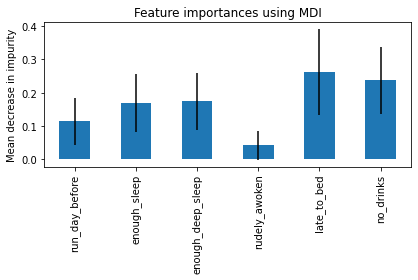

In [732]:
importances = model.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

std = np.std([
    tree.feature_importances_ for tree in model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [733]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[23, 11],
       [ 7, 16]])